# Imports

In [ ]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 365 µs (started: 2023-02-20 22:03:10 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.39 s (started: 2023-02-20 22:03:10 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'ResNet50'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'inverted'

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_{}/splits/inverted_otsu/

versión Keras: 2.11.0
time: 1.48 ms (started: 2023-02-20 22:03:13 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 33.5 s (started: 2023-02-20 22:03:13 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet50_8G = keras.applications.ResNet50(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet50_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG):
    '''Guardar el modelo en disco duro
    
    Args:
        -SIZE: 64, 96, 112 ó 127
        -TFM_PATH = Ruta en drive a la carpeta del TFM
        -custom_model: Modelo de Deep Learning
        -TYPE_IMG: regular o inverted
    '''
    
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl8_imgs{SIZE}_' + TYPE_IMG +'__OTSU.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print(f'------ Model Saved in {WEIGHTS_PATH}-------')


time: 8.01 ms (started: 2023-02-20 22:04:24 +00:00)


# Imgs 64x64

- Test Accuracy: 0.4287930130958557
- Test Loss: 3.1887035369873047
- time: 29min 28s
- F1 score: 0.42451452969444164
- Precision score: 0.4852132092902991
- Recall:  0.4287930062041737
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 64 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 566 µs (started: 2023-02-20 22:04:27 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 5.99 s (started: 2023-02-20 22:04:27 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.27 ms (started: 2023-02-20 22:04:33 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

94765736/94765736 [==============================] - 0s 0us/step
time: 5.44 s (started: 2023-02-20 22:04:33 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 47s 11ms/step - loss: 6.5494 - sparse_categorical_accuracy: 0.0198 - val_loss: 6.3272 - val_sparse_categorical_accuracy: 0.0389
Epoch 2/50
3325/3325 [==============================] - 35s 11ms/step - loss: 6.1547 - sparse_categorical_accuracy: 0.0683 - val_loss: 6.0295 - val_sparse_categorical_accuracy: 0.0851
Epoch 3/50
3325/3325 [==============================] - 35s 10ms/step - loss: 5.8792 - sparse_categorical_accuracy: 0.1085 - val_loss: 5.7954 - val_sparse_categorical_accuracy: 0.1188
Epoch 4/50
3325/3325 [==============================] - 35s 11ms/step - loss: 5.6552 - sparse_categorical_accuracy: 0.1411 - val_loss: 5.6007 - val_sparse_categorical_accuracy: 0.1425
Epoch 5/50
3325/3325 [==============================] - 35s 11ms/step - loss: 5.4647 - sparse_categorical_accuracy: 0.1685 - val_loss: 5.4343 - val_sparse_categorical_accuracy: 0.1655
Epoch 6/50
3325/3325 [==============================] - 35s 11ms/step - loss: 5.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.41 s (started: 2023-02-20 22:34:08 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 5s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.4287930130958557
- Test Loss: 3.1887035369873047
- time: 
- F1 score: 0.42451452969444164
- Precision score: 0.4852132092902991
- Recall:  0.4287930062041737
- Epoch: 
*********************************************************************************************************************************
time: 9.47 s (started: 2023-02-20 22:34:09 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

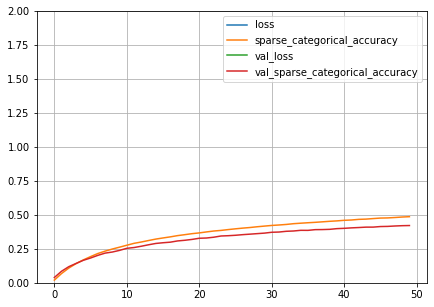

time: 258 ms (started: 2023-02-20 22:34:19 +00:00)


In [ ]:
plot_loss(history)

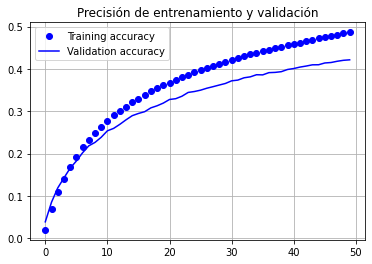

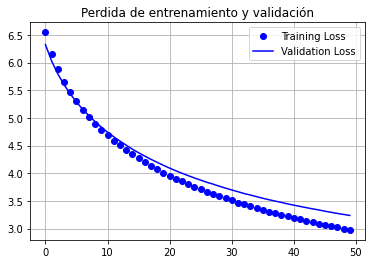

time: 397 ms (started: 2023-02-20 22:34:19 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/inverted/model_resnet50_etl8_imgs64_inverted__OTSU.h5-------
time: 2.25 s (started: 2023-02-20 22:34:20 +00:00)


# Imgs 96x96

- Test Accuracy: 0.5454737544059753
- Test Loss: 2.8986217975616455
- time: 32min 55s
- F1 score: 0.5453411745927987
- Precision score: 0.6072682008027642
- Recall:  0.5454737732656514
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 96 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 556 µs (started: 2023-02-20 22:34:22 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 5.85 s (started: 2023-02-20 22:34:22 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)


time: 2.12 ms (started: 2023-02-20 22:34:28 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.69 s (started: 2023-02-20 22:34:28 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 44s 12ms/step - loss: 6.6206 - sparse_categorical_accuracy: 0.0230 - val_loss: 6.4410 - val_sparse_categorical_accuracy: 0.0548
Epoch 2/50
3325/3325 [==============================] - 40s 12ms/step - loss: 6.2896 - sparse_categorical_accuracy: 0.0876 - val_loss: 6.1721 - val_sparse_categorical_accuracy: 0.1047
Epoch 3/50
3325/3325 [==============================] - 39s 12ms/step - loss: 6.0332 - sparse_categorical_accuracy: 0.1348 - val_loss: 5.9447 - val_sparse_categorical_accuracy: 0.1484
Epoch 4/50
3325/3325 [==============================] - 39s 12ms/step - loss: 5.8122 - sparse_categorical_accuracy: 0.1822 - val_loss: 5.7457 - val_sparse_categorical_accuracy: 0.1917
Epoch 5/50
3325/3325 [==============================] - 39s 12ms/step - loss: 5.6171 - sparse_categorical_accuracy: 0.2192 - val_loss: 5.5698 - val_sparse_categorical_accuracy: 0.2089
Epoch 6/50
3325/3325 [==============================] - 39s 12ms/step - loss: 5.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.6 s (started: 2023-02-20 23:07:25 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 6s 9ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5454737544059753
- Test Loss: 2.8986217975616455
- time: 
- F1 score: 0.5453411745927987
- Precision score: 0.6072682008027642
- Recall:  0.5454737732656514
- Epoch: 
*********************************************************************************************************************************
time: 10.8 s (started: 2023-02-20 23:07:27 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

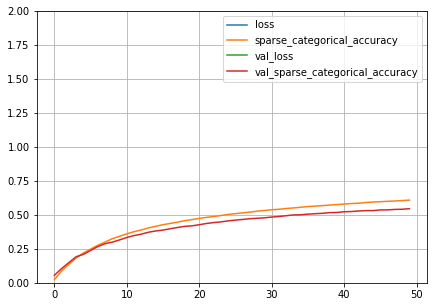

time: 195 ms (started: 2023-02-20 23:07:38 +00:00)


In [ ]:
plot_loss(history)

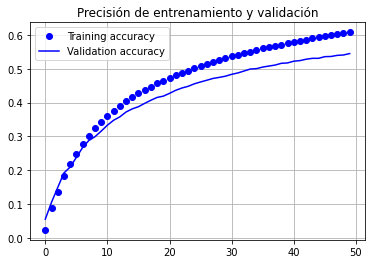

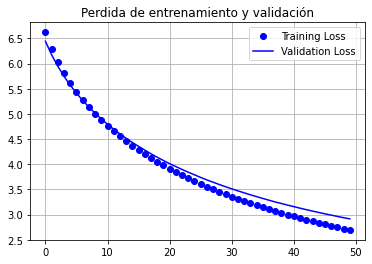

time: 416 ms (started: 2023-02-20 23:07:38 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/inverted/model_resnet50_etl8_imgs96_inverted__OTSU.h5-------
time: 637 ms (started: 2023-02-20 23:07:38 +00:00)


# Imgs 112x112

- Test Accuracy: 0.679498016834259
- Test Loss: 1.7513682842254639
- time: 34min 50s
- F1 score: 0.6810161161758828
- Precision score: 0.7110779169513857
- Recall:  0.6794980259447264
- Epoch: 50/50

## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 618 µs (started: 2023-02-20 23:07:39 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 6.99 s (started: 2023-02-20 23:07:39 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 951 µs (started: 2023-02-20 23:07:46 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.75 s (started: 2023-02-20 23:07:46 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_2[0][0]']    

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 46s 13ms/step - loss: 6.3061 - sparse_categorical_accuracy: 0.0376 - val_loss: 5.9439 - val_sparse_categorical_accuracy: 0.0726
Epoch 2/50
3325/3325 [==============================] - 41s 12ms/step - loss: 5.6629 - sparse_categorical_accuracy: 0.1274 - val_loss: 5.4647 - val_sparse_categorical_accuracy: 0.1531
Epoch 3/50
3325/3325 [==============================] - 41s 12ms/step - loss: 5.2290 - sparse_categorical_accuracy: 0.2015 - val_loss: 5.0990 - val_sparse_categorical_accuracy: 0.2123
Epoch 4/50
3325/3325 [==============================] - 41s 12ms/step - loss: 4.8816 - sparse_categorical_accuracy: 0.2576 - val_loss: 4.8005 - val_sparse_categorical_accuracy: 0.2602
Epoch 5/50
3325/3325 [==============================] - 42s 12ms/step - loss: 4.5905 - sparse_categorical_accuracy: 0.3075 - val_loss: 4.5441 - val_sparse_categorical_accuracy: 0.3011
Epoch 6/50
3325/3325 [==============================] - 41s 12ms/step - loss: 4.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.65 s (started: 2023-02-20 23:42:39 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 5s 9ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.679498016834259
- Test Loss: 1.7513682842254639
- time: 
- F1 score: 0.6810161161758828
- Precision score: 0.7110779169513857
- Recall:  0.6794980259447264
- Epoch: 
*********************************************************************************************************************************
time: 10.3 s (started: 2023-02-20 23:42:40 +00:00)


## Graficando

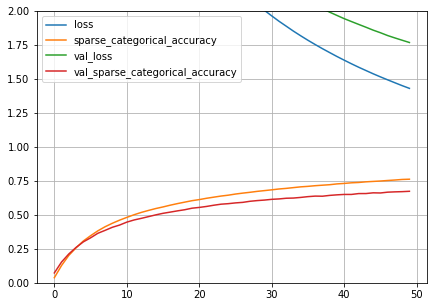

time: 204 ms (started: 2023-02-20 23:42:51 +00:00)


In [ ]:
plot_loss(history)

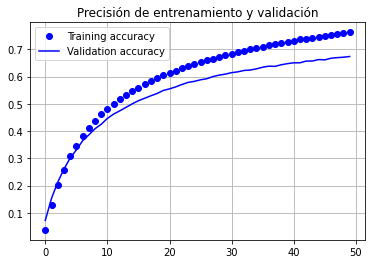

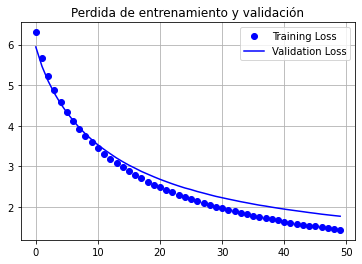

time: 394 ms (started: 2023-02-20 23:42:51 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/inverted/model_resnet50_etl8_imgs112_inverted__OTSU.h5-------
time: 649 ms (started: 2023-02-20 23:42:51 +00:00)


# Imgs 127x127

- Test Accuracy: 0.5907360315322876
- Test Loss: 2.8539879322052
- time: 36min 42s
- F1 score: 0.5933361698043103
- Precision score: 0.6548275102506248
- Recall:  0.5907360406091371
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 559 µs (started: 2023-02-20 23:42:52 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 8.22 s (started: 2023-02-20 23:42:52 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 947 µs (started: 2023-02-20 23:43:00 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.96 s (started: 2023-02-20 23:43:00 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate_3[0][0]']    

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 47s 13ms/step - loss: 6.6441 - sparse_categorical_accuracy: 0.0193 - val_loss: 6.4815 - val_sparse_categorical_accuracy: 0.0393
Epoch 2/50
3325/3325 [==============================] - 44s 13ms/step - loss: 6.3426 - sparse_categorical_accuracy: 0.0725 - val_loss: 6.2310 - val_sparse_categorical_accuracy: 0.0991
Epoch 3/50
3325/3325 [==============================] - 42s 13ms/step - loss: 6.1036 - sparse_categorical_accuracy: 0.1270 - val_loss: 6.0160 - val_sparse_categorical_accuracy: 0.1411
Epoch 4/50
3325/3325 [==============================] - 43s 13ms/step - loss: 5.8946 - sparse_categorical_accuracy: 0.1724 - val_loss: 5.8252 - val_sparse_categorical_accuracy: 0.1874
Epoch 5/50
3325/3325 [==============================] - 42s 13ms/step - loss: 5.7080 - sparse_categorical_accuracy: 0.2177 - val_loss: 5.6565 - val_sparse_categorical_accuracy: 0.2099
Epoch 6/50
3325/3325 [==============================] - 44s 13ms/step - loss: 5.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.84 s (started: 2023-02-21 00:19:46 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 5s 10ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5907360315322876
- Test Loss: 2.8539879322052
- time: 
- F1 score: 0.5933361698043103
- Precision score: 0.6548275102506248
- Recall:  0.5907360406091371
- Epoch: 
*********************************************************************************************************************************
time: 10.8 s (started: 2023-02-21 00:19:48 +00:00)


## Graficando


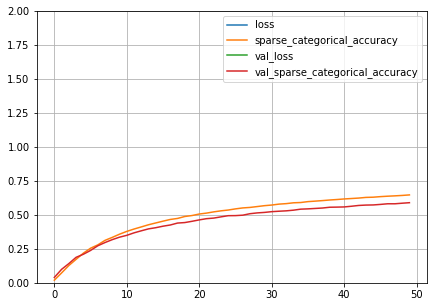

time: 195 ms (started: 2023-02-21 00:19:59 +00:00)


In [ ]:
plot_loss(history)

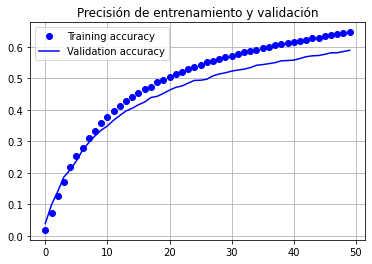

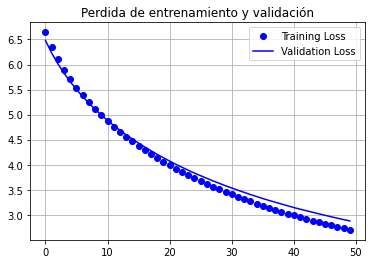

time: 392 ms (started: 2023-02-21 00:19:59 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/inverted/model_resnet50_etl8_imgs127_inverted__OTSU.h5-------
time: 639 ms (started: 2023-02-21 00:19:59 +00:00)


In [ ]:
runtime.unassign()

time: 374 ms (started: 2023-02-21 00:20:00 +00:00)
